# ILPD Dataset

## Présentation du Dataset

### 1. Description du Dataset
Le dataset utilisé provient d'une étude sur la prédiction des maladies du foie et contient des informations médicales de 583 patients provenant du nord-est de l'Andhra Pradesh, en Inde. L'objectif est de déterminer si un patient souffre d'une maladie du foie en fonction de plusieurs marqueurs biochimiques.

- **Nombre total d'instances :** 583 patients
- **Nombre total d'attributs :**10 caractéristiques médicales + 1 classe cible
- **Classes cibles :**Indique si le patient est atteint d'une maladie du foie ou non (classification binaire)

### 2. Attributs du Dataset
1. **Age** : Âge du patient (toute personne de plus de 89 ans est indiquée comme ayant 90 ans).
2. **Gender** : Sexe du patient (masculin ou féminin).
3. **Total Bilirubin (TB)** : Niveau total de bilirubine dans le sang.
4. **Direct Bilirubin (DB) :** :Niveau de bilirubine directe.
5. **Alkaline Phosphatase (Alkphos)** : Niveau de phosphatase alcaline.
6. **Alanine Aminotransferase (SGPT)** : Niveau d'alanine aminotransférase.
7. **Aspartate Aminotransferase (SGOT)** : Niveau d'aspartate aminotransférase.
8. **Total Proteins (TP)** : Concentration totale de protéines dans le sang.
9. **Albumin (ALB)** : Niveau d'albumine dans le sang.
10. **Albumin and Globulin Ratio (A/G Ratio)** : Rapport albumine/globuline.
11. **Selector** : Indique si le patient est atteint d'une maladie du foie (1) ou non (2).

## Méthodologie de Sélection de Variables

Nous allons comparer trois approches de sélection de variables afin d'améliorer la performance de la classification :

### 1. **Recherche exhaustive** (Exhaustive Search)
Nous testons toutes les combinaisons possibles d'attributs pour identifier la meilleure sélection en fonction de plusieurs métriques (accuracy, F1-score, précision). Cette approche est coûteuse en temps de calcul mais garantit d'identifier l'ensemble optimal de variables.

### 2. **Sélection séquentielle avant (SFS Forward)**
Nous commençons avec un seul attribut et ajoutons progressivement ceux qui améliorent le plus la performance du modèle.

### 3. **Sélection séquentielle arrière (SFS Backward)**
Nous commençons avec tous les attributs et supprimons progressivement ceux qui ont le moins d'impact sur la performance.

# KNN (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec KNN 

In [3]:
import pandas as pd
import time 
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_knn = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_knn

    start_time = time.time()
    
    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/hp/Downloads/results_KNN_ILPD.xlsx', index=False)
    global_results_df_knn = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")


     # Calcul du temps d'exécution
    execution_time = (time.time() - start_time) / 60
    print(f"Temps d'exécution : {execution_time:.2f} minutes")
    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/hp/Desktop/ILPD.csv', header=None)

# Initialisation du modèle KNN
classifier = KNeighborsClassifier(n_neighbors=3)

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_knn.head())

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

Best mean accuracy: 0.7203
Best mean f1-score: 0.7110
Best mean precision: 0.7180
Temps d'exécution : 44.81 minutes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  feature10  mean_accuracy  mean_f1_score  \
0         0         0          0       0.000000       0.000000   
1         0         0          0       0.663671       0.649215   
2         0         0          0       0.691330       0.604733   
3         0         0          0       0.651758       0.621519   
4         0         0          0       0.686060       0.606511   

   mean_p

## SFS (backward + forward), accuracy_score, KNN

C:\Users\hp\AppData\Local\Temp\ipykernel_30028\1310956397.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   | ✔   |     | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     | ✔   |     | ✔   |     |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     |     | ✔   |     | ✔   |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7203
Score SFS Forward : 0.6743
Score SFS Backward : 0.6914
Gap2 SFS Forward : 0.0976 | Gap2 SFS Backward : 0.0594


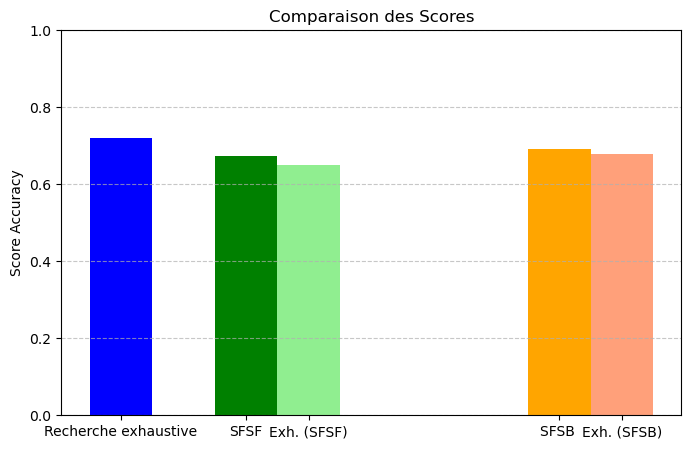

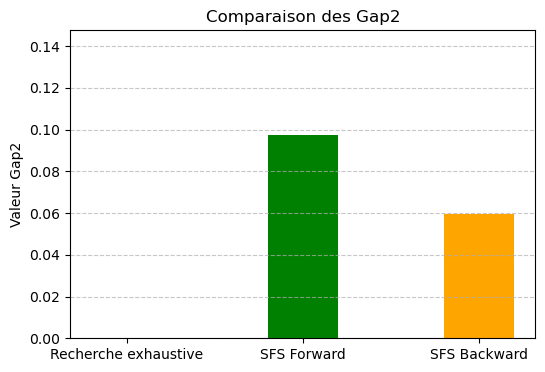

Temps d'exécution : 13.70 secondes


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score Accuracy', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1_score, KNN

C:\Users\hp\AppData\Local\Temp\ipykernel_30028\3914264954.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   | ✔   |     | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     | ✔   |     | ✔   |     |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     |     | ✔   |     | ✔   |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7110
Score SFS Forward : 0.3448
Score SFS Backward : 0.3721
Gap2 SFS Forward : 0.0955 | Gap2 SFS Backward : 0.0578


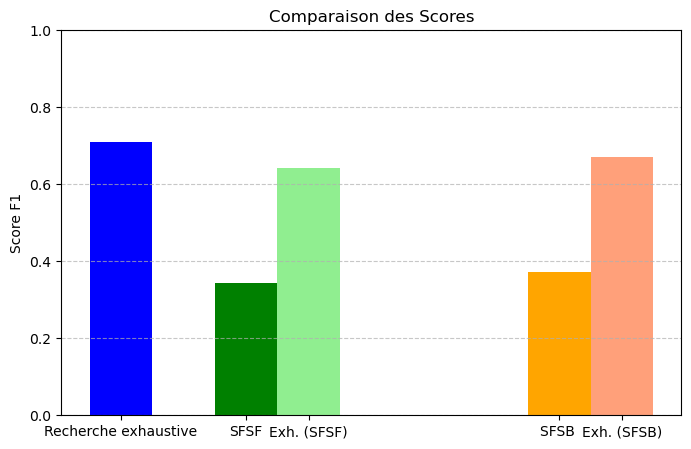

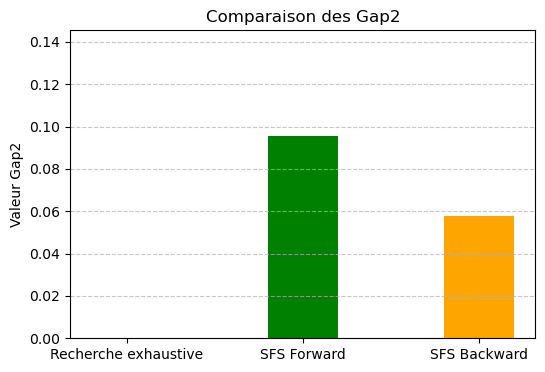

Temps d'exécution : 15.71 secondes


In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score F1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, KNN

C:\Users\hp\AppData\Local\Temp\ipykernel_30028\201843200.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   | ✔   |     | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     | ✔   |     | ✔   |     |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     | ✔   |     |     | ✔   |     | ✔   |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7180
Score SFS Forward : 0.4054
Score SFS Backward : 0.4444
Gap2 SFS Forward : 0.0866 | Gap2 SFS Backward : 0.0598


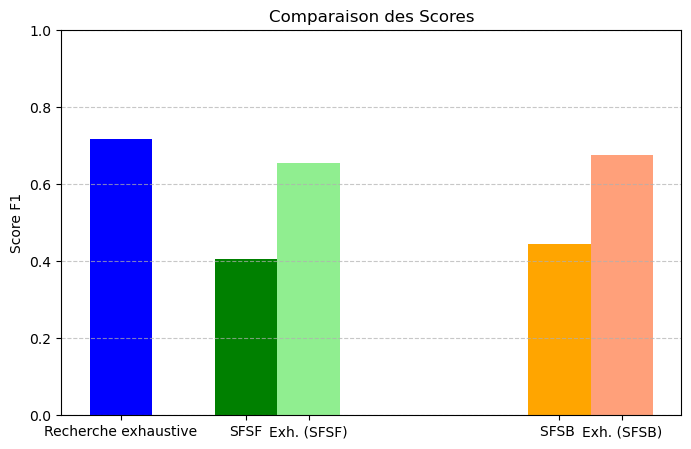

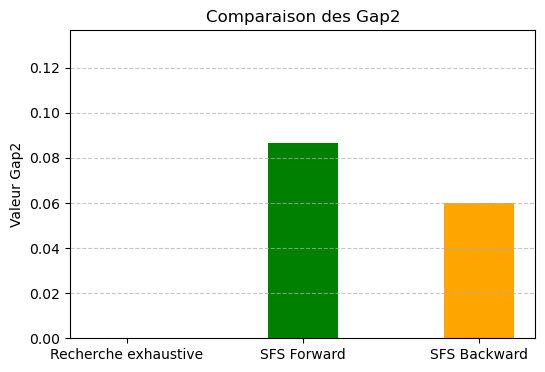

Temps d'exécution : 13.28 secondes


In [6]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_knn  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_knn['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_knn.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_knn[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_knn.loc[global_results_df_knn['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score F1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=KNeighborsClassifier(n_neighbors=5),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# XGB (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec XGB 

In [1]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
import time
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_xgb = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_xgb

    start_time = time.time() #debut du chronometre
    
    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/hp/Downloads/results_XGB_ILPD.xlsx', index=False)
    global_results_df_xgb = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")


    # Calcul du temps d'exécution
    execution_time = (time.time() - start_time) / 60
    print(f"Temps d'exécution : {execution_time:.2f} minutes")

    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/hp/Desktop/ILPD.csv', header=None)

# Initialisation du modèle KNN
classifier = XGBClassifier(eval_metric='logloss')

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_xgb.head())

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

Best mean accuracy: 0.7170
Best mean f1-score: 0.7107
Best mean precision: 0.7177
Temps d'exécution : 49.55 minutes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  feature10  mean_accuracy  mean_f1_score  \
0         0         0          0       0.000000       0.000000   
1         0         0          0       0.677434       0.654012   
2         0         0          0       0.713552       0.594272   
3         0         0          0       0.675804       0.615837   
4         0         0          0       0.711834       0.601838   

   mean_p

## SFS (backward + forward), accuracy_score, XGB

C:\Users\hp\AppData\Local\Temp\ipykernel_17436\2108168844.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     |     |     |     | ✔   | ✔   |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     | ✔   | ✔   |     |     |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     | ✔   | ✔   |     |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7170
Score SFS Forward : 0.6629
Score SFS Backward : 0.7029
Gap2 SFS Forward : 0.0551 | Gap2 SFS Backward : 0.0647


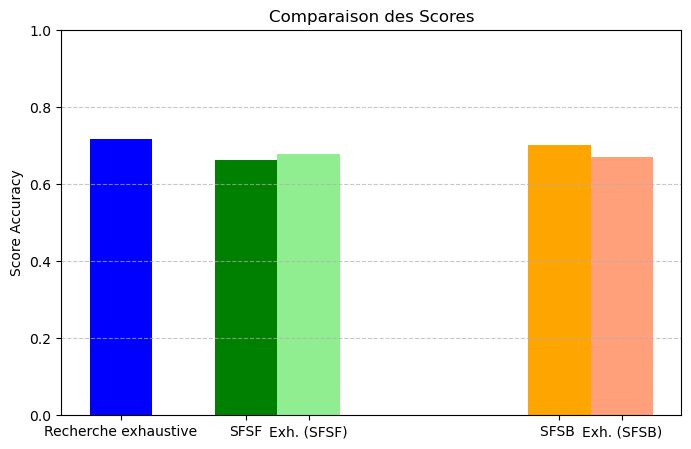

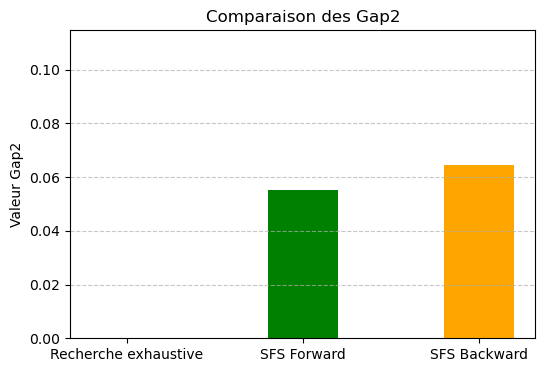

Temps d'exécution : 21.65 secondes


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score Accuracy', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1_score, XGB

C:\Users\hp\AppData\Local\Temp\ipykernel_17436\1082603023.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     |     |     |     | ✔   | ✔   |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     | ✔   | ✔   |     |     |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     | ✔   | ✔   |     |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7107
Score SFS Forward : 0.3059
Score SFS Backward : 0.4468
Gap2 SFS Forward : 0.0681 | Gap2 SFS Backward : 0.0742


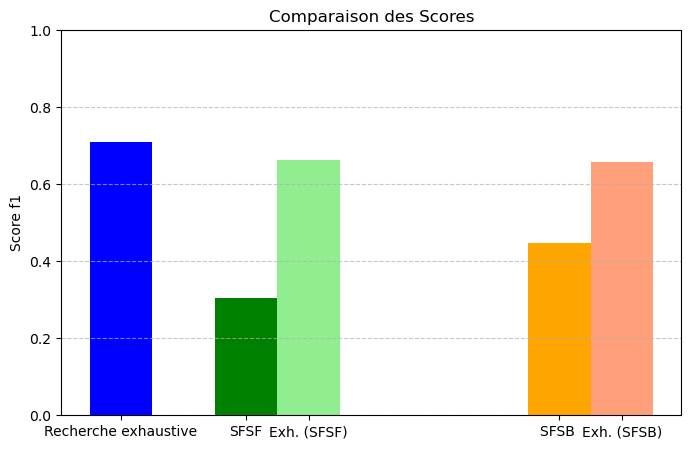

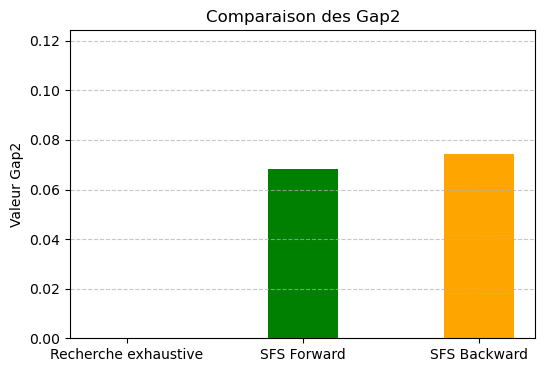

Temps d'exécution : 21.28 secondes


In [5]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, XGB

C:\Users\hp\AppData\Local\Temp\ipykernel_17436\3850398692.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   | ✔   |     | ✔   |     |     | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     | ✔   | ✔   |     |     |     | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     | ✔   | ✔   |     |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7177
Score SFS Forward : 0.3714
Score SFS Backward : 0.4773
Gap2 SFS Forward : 0.0869 | Gap2 SFS Backward : 0.0910


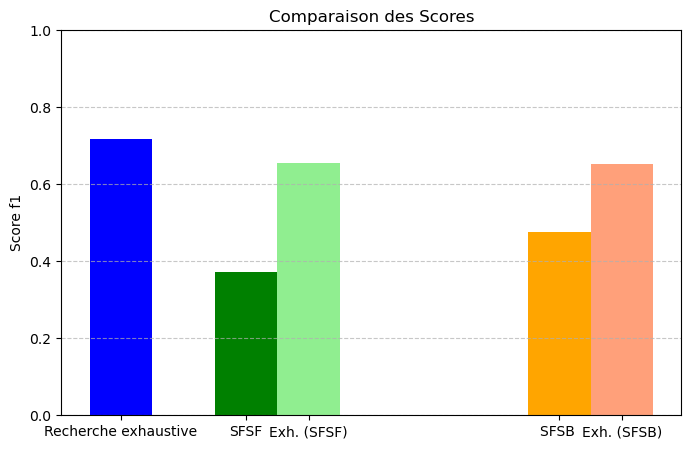

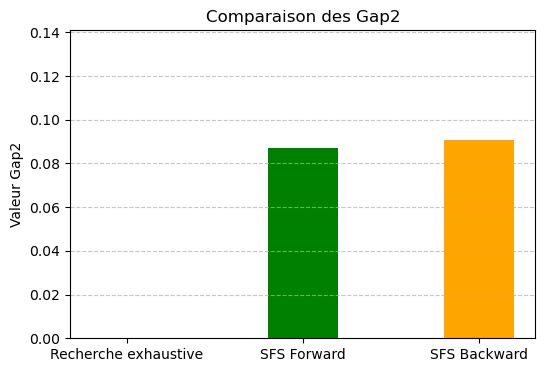

Temps d'exécution : 21.11 secondes


In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_xgb  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_xgb['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_xgb.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_xgb[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_xgb.loc[global_results_df_xgb['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=XGBClassifier(eval_metric='logloss'),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# Logit (accuracy, F1-score, précision)
## Sélection exhaustive des caractéristiques avec LogisticRegression 


In [9]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score
import numpy as np
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_logit = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_logit

    start_time = time.time() #debut du chronometre

    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()
    
    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "accuracy": make_scorer(accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')] 
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/hp/Downloads/results_LogReg_ILPD.xlsx', index=False)
    global_results_df_logit = results_df

    print(f"Best mean accuracy: {best_scores['accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")

     # Calcul du temps d'exécution
    execution_time = (time.time() - start_time) / 60
    print(f"Temps d'exécution : {execution_time:.2f} minutes")

    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/hp/Desktop/ILPD.csv', header=None)

# Initialisation du modèle KNN
classifier = LogisticRegression(max_iter=1000)

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_logit.head())

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hp\Documents\Python Scripts\Lib\site-packages\skl

Best mean accuracy: 0.7376
Best mean f1-score: 0.7101
Best mean precision: 0.7520
Temps d'exécution : 8.49 minutes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  feature10  mean_accuracy  mean_f1_score  \
0         0         0          0       0.000000       0.000000   
1         0         0          0       0.713552       0.594272   
2         0         0          0       0.713552       0.594272   
3         0         0          0       0.713552       0.594272   
4         0         0          0       0.713552       0.594272   

   mean_pr

## SFS (backward + forward), accuracy_score, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     |     | ✔   | ✔   | ✔   |     | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     |     | ✔   | ✔   | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     |     | ✔   | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7376
Score SFS Forward : 0.7143
Score SFS Backward : 0.7029
Gap2 SFS Forward : 0.0326 | Gap2 SFS Backward : 0.0442


C:\Users\hp\AppData\Local\Temp\ipykernel_17436\3636370832.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


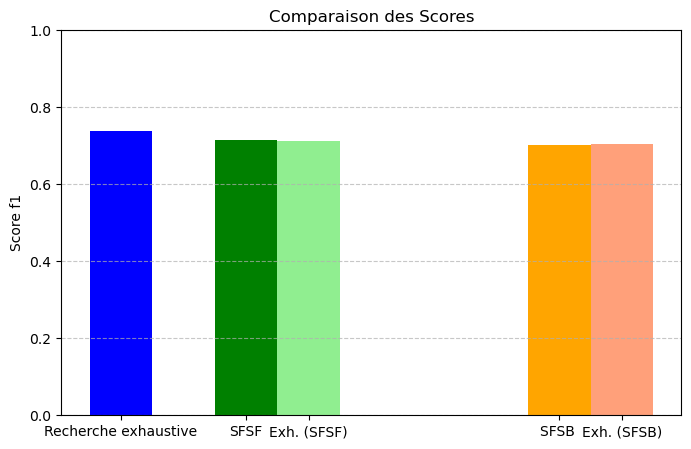

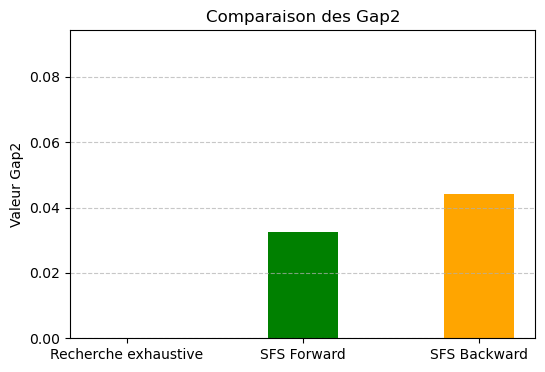

Temps d'exécution : 4.13 secondes


In [10]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), f1, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   |     |     | ✔   | ✔   | ✔   |     | ✔   | ✔   | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     |     | ✔   | ✔   | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     |     | ✔   | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7101
Score SFS Forward : 0.3056
Score SFS Backward : 0.2571
Gap2 SFS Forward : 0.0415 | Gap2 SFS Backward : 0.0702


C:\Users\hp\AppData\Local\Temp\ipykernel_17436\1726862444.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


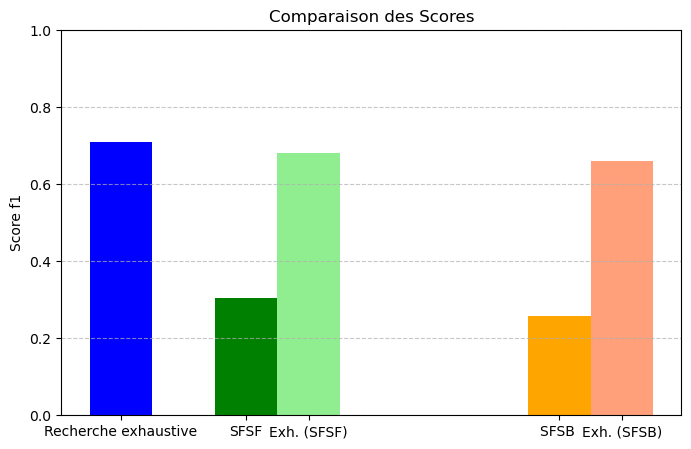

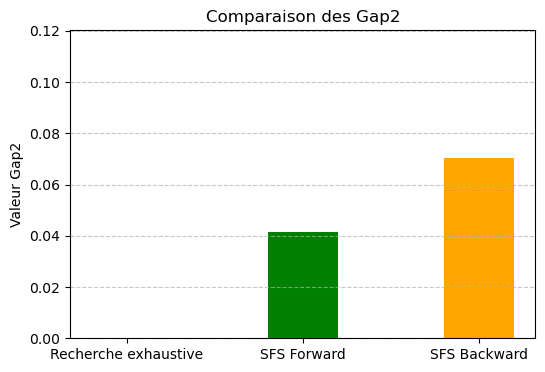

Temps d'exécution : 3.84 secondes


In [11]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_f1_score'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=f1_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward), precision_score, LOGIT

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive |     |     | ✔   | ✔   |     |     |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   | ✔   |     |     | ✔   | ✔   | ✔   |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   | ✔   |     |     | ✔   | ✔   |     | ✔   |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7520
Score SFS Forward : 0.5000
Score SFS Backward : 0.4500
Gap2 SFS Forward : 0.0819 | Gap2 SFS Backward : 0.1097


C:\Users\hp\AppData\Local\Temp\ipykernel_17436\2037272763.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


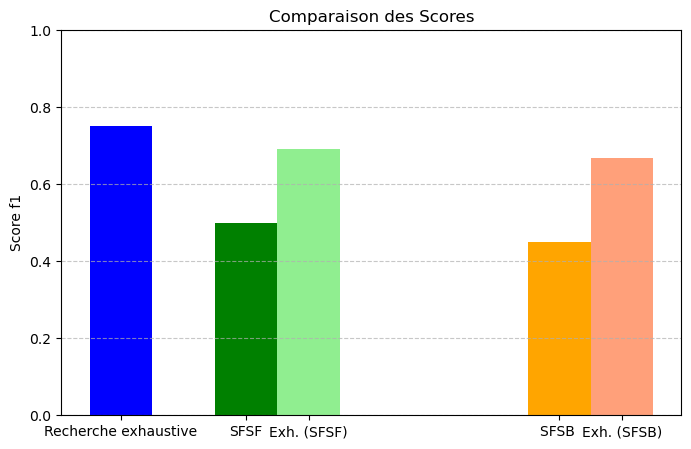

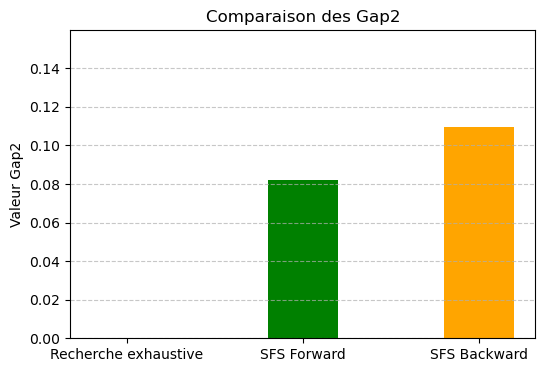

Temps d'exécution : 3.76 secondes


In [12]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logit  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logit['mean_precision'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logit.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logit[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logit.loc[global_results_df_logit['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000),
    score_func=precision_score,
    cv_sfs=3,
    seed=1
)


# Logistic Regression en ajustant les hyperparameteres max_iter=1000 et class_weight="balanced" en utilisant la metrique balanced accuracy

In [1]:
import pandas as pd
from itertools import combinations
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, balanced_accuracy_score, f1_score, precision_score
import numpy as np
import time
import random

# Déclaration d'une variable globale pour stocker les résultats
global_results_df_logittt = None

def evaluate_feature_combinations(data, classifier, cv=3, seed=3):
    global global_results_df_logittt

    start_time = time.time()  # Début du chronomètre

    # Encode categorical attributes
    label_encoders = {}
    for column in data.columns:
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

    X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière
    y = data.iloc[:, -1]   # Seulement la dernière colonne

    # Vérification de l'équilibre des classes
    class_counts = y.value_counts()
    min_class_size = class_counts.min()

    if min_class_size < cv:
        print(f"Reducing cv from {cv} to {min_class_size} due to class imbalance.")
        cv = min_class_size

    features = X.columns.tolist()
    results = []
    subsets = [()] + [subset for r in range(1, len(features) + 1) for subset in combinations(features, r)]

    # Définir les métriques à tester
    scoring_metrics = {
        "balanced_accuracy": make_scorer(balanced_accuracy_score),
        "f1_score": make_scorer(f1_score, average='weighted'),
        "precision": make_scorer(precision_score, average='weighted')
    }

    for subset in subsets:
        scores_dict = {metric: [] for metric in scoring_metrics.keys()}

        for s in range(seed):
            random.seed(s)

            if len(subset) == 0:
                X_selected = pd.DataFrame(index=X.index)
            else:
                X_selected = X[list(subset)]

            try:
                for metric, scorer in scoring_metrics.items():
                    cv_scores = cross_val_score(classifier, X_selected, y, cv=cv, scoring=scorer)
                    scores_dict[metric].extend(cv_scores)
            except ValueError:
                for metric in scoring_metrics.keys():
                    scores_dict[metric] = [0] * cv

        # Stocker les moyennes des scores pour chaque métrique
        row = {f'feature{features.index(feature) + 1}': 1 if feature in subset else 0 for feature in features}
        for metric in scoring_metrics.keys():
            row[f'mean_{metric}'] = np.mean(scores_dict[metric])

        results.append(row)

    results_df = pd.DataFrame(results)

    # Trouver les meilleurs scores pour chaque métrique
    best_scores = {metric: results_df[f'mean_{metric}'].max() for metric in scoring_metrics.keys()}

    # Ajouter les écarts par rapport aux meilleurs scores
    for metric in scoring_metrics.keys():
        results_df[f'gap1_{metric}'] = best_scores[metric] - results_df[f'mean_{metric}']
        results_df[f'gap2_{metric}'] = results_df[f'gap1_{metric}'] / best_scores[metric]

    ordered_columns = [col for col in results_df.columns if col.startswith('feature')]
    ordered_columns += [f'mean_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap1_{metric}' for metric in scoring_metrics.keys()]
    ordered_columns += [f'gap2_{metric}' for metric in scoring_metrics.keys()]

    results_df = results_df[ordered_columns]

    # Sauvegarde dans un fichier Excel
    results_df.to_excel('C:/Users/hp/Downloads/AAresults_LogReg_ILPD.xlsx', index=False)
    global_results_df_logittt = results_df

    print(f"Best mean balanced accuracy: {best_scores['balanced_accuracy']:.4f}")
    print(f"Best mean f1-score: {best_scores['f1_score']:.4f}")
    print(f"Best mean precision: {best_scores['precision']:.4f}")

    # Calcul du temps d'exécution
    execution_time = (time.time() - start_time) / 60
    print(f"Temps d'exécution : {execution_time:.2f} minutes")

    return results_df

# Chargement des données
data = pd.read_csv('C:/Users/hp/Desktop/ILPD.csv', header=None)

# Initialisation du modèle de régression logistique avec balance des classes
classifier = LogisticRegression(max_iter=1000, class_weight="balanced")

# Exécution de la fonction avec plusieurs métriques
df_results = evaluate_feature_combinations(data, classifier, cv=3, seed=3)

# Affichage des résultats globaux
print("\n--- Résultats globaux ---")
print(global_results_df_logittt.head())


Best mean balanced accuracy: 0.7099
Best mean f1-score: 0.6755
Best mean precision: 0.7737
Temps d'exécution : 8.54 minutes

--- Résultats globaux ---
   feature1  feature2  feature3  feature4  feature5  feature6  feature7  \
0         0         0         0         0         0         0         0   
1         1         0         0         0         0         0         0   
2         0         1         0         0         0         0         0   
3         0         0         1         0         0         0         0   
4         0         0         0         1         0         0         0   

   feature8  feature9  feature10  mean_balanced_accuracy  mean_f1_score  \
0         0         0          0                0.000000       0.000000   
1         0         0          0                0.573829       0.591965   
2         0         0          0                0.539166       0.631645   
3         0         0          0                0.657422       0.572875   
4         0         0  

## SFS (backward + forward), balanced_accuracy_score, LOGIT

C:\Users\hp\AppData\Local\Temp\ipykernel_11088\1248490707.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   |     | ✔   | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   |     |     |     | ✔   | ✔   |     | ✔   |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     |     |     | ✔   | ✔   |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7099
Score SFS Forward : 0.6500
Score SFS Backward : 0.6500
Gap2 SFS Forward : 0.0549 | Gap2 SFS Backward : 0.0774


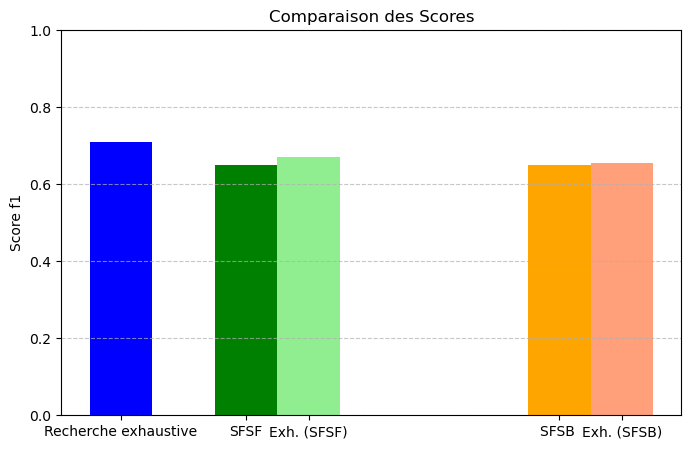

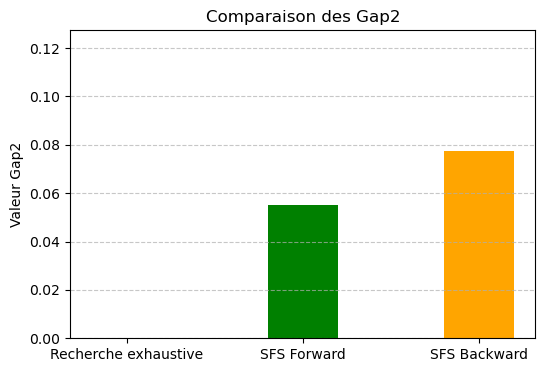

Temps d'exécution : 3.70 secondes


In [4]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score 
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logittt  # Accéder au dataframe global

    start_time = time.time() #debut du chronometre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logittt.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logittt[mask]
        if not matching_row.empty:
            return matching_row['gap2_balanced_accuracy'].values[0]
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logittt['mean_balanced_accuracy'].max()


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logittt.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logittt[mask]
        if not matching_row.empty:
            return matching_row['mean_balanced_accuracy'].values[0]
        return None
    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logittt.loc[global_results_df_logittt['mean_balanced_accuracy'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    
    


    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    # print(f"Features sélectionnés (SFS Forward) : {selected_features_f}")
    
    # print(f"Features sélectionnés (SFS Backward) : {selected_features_b}")
    
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000,class_weight="balanced"),
    score_func=balanced_accuracy_score,
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward),f1_score, LOGIT avec lhyperparametre class_weight="balanced"

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   |     | ✔   | ✔   | ✔   |     |     |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   |     |     |     | ✔   | ✔   |     | ✔   |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     |     |     | ✔   | ✔   |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.6755
Score SFS Forward : 0.5156
Score SFS Backward : 0.5156
Gap2 SFS Forward : 0.0193 | Gap2 SFS Backward : 0.0366


C:\Users\hp\AppData\Local\Temp\ipykernel_11088\699230364.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


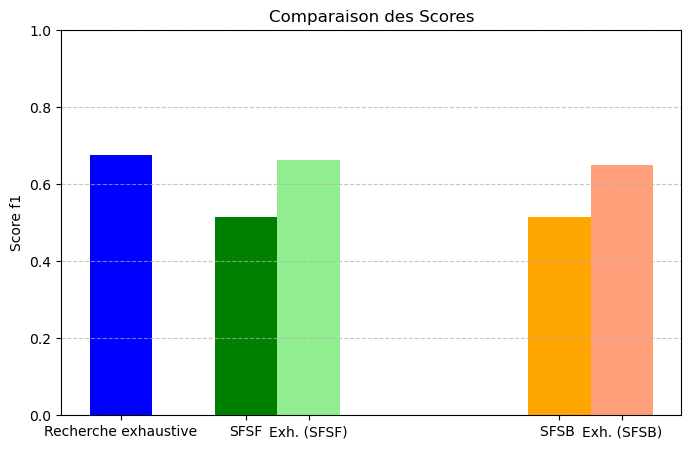

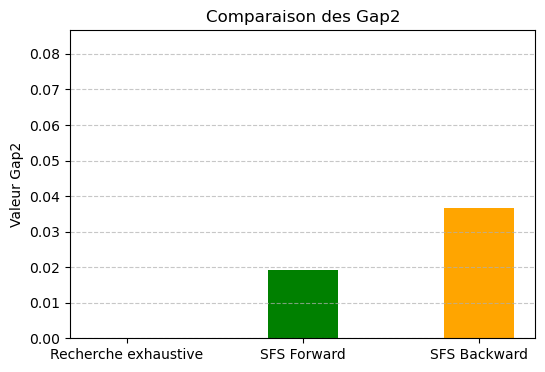

Temps d'exécution : 4.31 secondes


In [7]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score  
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logittt  # Accéder au dataframe global

    start_time = time.time() #début du chronomètre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)  # Utilisation de f1_score

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logittt.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logittt[mask]
        if not matching_row.empty:
            return matching_row['gap2_f1_score'].values[0]  # Changer le nom de la colonne
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logittt['mean_f1_score'].max()  # Changer le nom de la colonne


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logittt.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logittt[mask]
        if not matching_row.empty:
            return matching_row['mean_f1_score'].values[0]  # Changer le nom de la colonne
        return None

    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logittt.loc[global_results_df_logittt['mean_f1_score'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Score f1', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000,class_weight="balanced"),
    score_func=f1_score,  # Remplacer par f1_score
    cv_sfs=3,
    seed=1
)


## SFS (backward + forward),precision_score, LOGIT avec lhyperparametre class_weight="balanced"

+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                      | 0   | 1   | 2   | 3   | 4   | 5   | 6   | 7   | 8   | 9   |
+======================+=====+=====+=====+=====+=====+=====+=====+=====+=====+=====+
| Recherche exhaustive | ✔   | ✔   |     | ✔   | ✔   | ✔   |     |     |     |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Forward          | ✔   |     |     |     | ✔   | ✔   |     | ✔   |     | ✔   |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
| SFS Backward         | ✔   |     |     |     | ✔   | ✔   |     | ✔   | ✔   |     |
+----------------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
Meilleur score Recherche Exhaustive : 0.7737
Score SFS Forward : 0.4231
Score SFS Backward : 0.4231
Gap2 SFS Forward : 0.0525 | Gap2 SFS Backward : 0.0666


C:\Users\hp\AppData\Local\Temp\ipykernel_11088\4241972624.py:94: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]


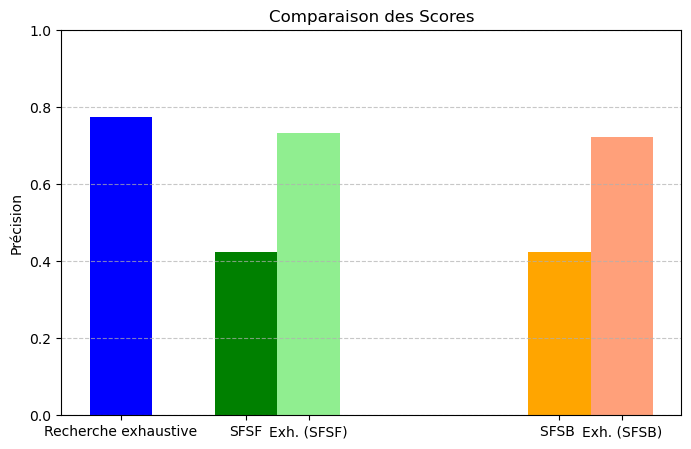

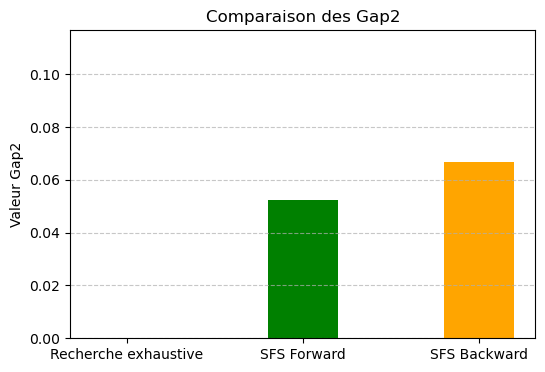

Temps d'exécution : 3.28 secondes


In [8]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score  # Importer precision_score
from sklearn.model_selection import train_test_split


def evaluate_features_with_sfs_and_compare(dataset_path, model, score_func, cv_sfs=3, seed=1):
    global global_results_df_logittt  # Accéder au dataframe global

    start_time = time.time()  # Début du chronomètre
    
    # Charger le dataset
    df = pd.read_csv(dataset_path, header=None)
    label_encoders = {}

    # Encoder les attributs catégoriels
    for column in df.columns:
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

    # Séparer les features (X) et la cible (y)
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]

    # Diviser les données en train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    # Appliquer SFS Forward et Backward
    sfs_forward = SequentialFeatureSelector(model, direction='forward', cv=cv_sfs)
    sfs_backward = SequentialFeatureSelector(model, direction='backward', cv=cv_sfs)
    
    sfs_forward.fit(X_train, y_train)
    sfs_backward.fit(X_train, y_train)

    # Récupérer les features sélectionnés
    def get_selected_features(sfs):
        selected_features = sfs.get_support(indices=True)
        return [X.columns[i] for i in selected_features], selected_features

    selected_features_f, selected_indices_f = get_selected_features(sfs_forward)
    selected_features_b, selected_indices_b = get_selected_features(sfs_backward)

    # Fonction d'évaluation
    def evaluate_selected_features(selected_indices, X_train, X_test, y_train, y_test, model):
        X_train_selected = X_train.iloc[:, selected_indices]
        X_test_selected = X_test.iloc[:, selected_indices]
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        return score_func(y_test, y_pred)  # Utilisation de precision_score

    score_forward = evaluate_selected_features(selected_indices_f, X_train, X_test, y_train, y_test, model)
    score_backward = evaluate_selected_features(selected_indices_b, X_train, X_test, y_train, y_test, model)

    # Trouver la correspondance dans la recherche exhaustive
    def get_gap2_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logittt.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logittt[mask]
        if not matching_row.empty:
            return matching_row['gap2_precision'].values[0]  # Remplacer par gap2_precision
        return None

    gap2_forward = get_gap2_for_selected_features(selected_indices_f)
    gap2_backward = get_gap2_for_selected_features(selected_indices_b)
    best_exhaustive_score = global_results_df_logittt['mean_precision'].max()  # Remplacer par mean_precision


    # Trouver la correspondance dans la recherche exhaustive
    def get_score_for_selected_features(selected_indices):
        num_features_global = X.shape[1]
        selected_binary = [1 if i in selected_indices else 0 for i in range(num_features_global)]
        mask = (global_results_df_logittt.iloc[:, :num_features_global] == selected_binary).all(axis=1)
        matching_row = global_results_df_logittt[mask]
        if not matching_row.empty:
            return matching_row['mean_precision'].values[0]  # Remplacer par mean_precision
        return None

    # Scores de la recherche exhaustive avec les combinaisons trouvées par SFS
    exhaustive_score_f = get_score_for_selected_features(selected_indices_f)
    exhaustive_score_b = get_score_for_selected_features(selected_indices_b)

    # Création du tableau des combinaisons
    features_list = list(X.columns)
    results_table = pd.DataFrame(index=['Recherche exhaustive', 'SFS Forward', 'SFS Backward'], columns=features_list)
    
    # Trouver les attributs correspondant au meilleur score de recherche exhaustive
    best_exhaustive_row = global_results_df_logittt.loc[global_results_df_logittt['mean_precision'].idxmax()]
    best_exhaustive_features = [features_list[i] for i in range(len(features_list)) if best_exhaustive_row[i] == 1]
    
    for feature in features_list:
        results_table.loc['Recherche exhaustive', feature] = '✔' if feature in best_exhaustive_features else ''
        results_table.loc['SFS Forward', feature] = '✔' if feature in selected_features_f else ''
        results_table.loc['SFS Backward', feature] = '✔' if feature in selected_features_b else ''

    from tabulate import tabulate

    print(tabulate(results_table, headers='keys', tablefmt='grid'))


    # Affichage des résultats
    print(f"Meilleur score Recherche Exhaustive : {best_exhaustive_score:.4f}")
    print(f"Score SFS Forward : {score_forward:.4f}")
    print(f"Score SFS Backward : {score_backward:.4f}")
    print(f"Gap2 SFS Forward : {gap2_forward:.4f} | Gap2 SFS Backward : {gap2_backward:.4f}")


    # Premier graphique : Comparaison des scores
    labels = ['Recherche exhaustive', 'SFSF', 'Exh. (SFSF)', 'SFSB ', 'Exh. (SFSB)']
    scores = [best_exhaustive_score, score_forward, exhaustive_score_f, score_backward, exhaustive_score_b]

    x = np.arange(len(labels))  # Positions de base des barres
    offset = 0.2  # Décalage pour rapprocher certaines barres

    x_modified = [x[0], x[1] - offset, x[1] + offset, x[3] - offset, x[3] + offset]
    
    plt.figure(figsize=(8, 5))  # Réduction de la taille
    plt.bar(x_modified, scores, color=['blue', 'green', 'lightgreen', 'orange', 'lightsalmon'], width=0.4)
    plt.title('Comparaison des Scores', fontsize=12)  # Taille du titre réduite
    plt.ylabel('Précision', fontsize=10)
    plt.xticks(x_modified, labels, fontsize=10)  # Réduction de la taille des labels
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille pour la lisibilité
    plt.show()
    
    # Deuxième graphique : Comparaison des Gap2
    gap2_values = [0, gap2_forward if gap2_forward is not None else 0, gap2_backward if gap2_backward is not None else 0]
    labels_gap2 = ['Recherche exhaustive', 'SFS Forward', 'SFS Backward']
    
    plt.figure(figsize=(6, 4))
    plt.bar(labels_gap2, gap2_values, color=['blue', 'green', 'orange'], width=0.4)
    plt.title('Comparaison des Gap2', fontsize=12)
    plt.ylabel('Valeur Gap2', fontsize=10)
    plt.xticks(fontsize=10)
    plt.ylim(0, max(gap2_values) + 0.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


    # Calcul du temps d'exécution
    execution_time = time.time() - start_time
    print(f"Temps d'exécution : {execution_time:.2f} secondes")

    return results_table, selected_features_f, selected_features_b, score_forward, score_backward

# Exemple d'utilisation
dataset_path = 'C:/Users/hp/Desktop/ILPD.csv'
results_table, selected_f, selected_b, score_f, score_b = evaluate_features_with_sfs_and_compare(
    dataset_path=dataset_path,
    model=LogisticRegression(max_iter=1000, class_weight="balanced"),
    score_func=precision_score,  # Remplacer par precision_score
    cv_sfs=3,
    seed=1
)
